<a href="https://colab.research.google.com/github/2303A510j3/Python-for-data-Science-project/blob/main/Python_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Step 1: Load dataset, EDA, and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import os

# Path to dataset (update if running in Colab)
csv_path = "/content/CollegePlacement.csv"
out_dir = "/content/ml_outputs"
os.makedirs(out_dir, exist_ok=True)

# Load data
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print(df.head())

# Encode categorical columns
le_intern = LabelEncoder()
df['Internship_Experience_enc'] = le_intern.fit_transform(df['Internship_Experience'])

le_place = LabelEncoder()
df['Placement_enc'] = le_place.fit_transform(df['Placement'])

# Drop ID & original categorical cols
df_model = df.drop(columns=['College_ID','Internship_Experience','Placement'])

# Features/Target
X = df_model.drop(columns=['Placement_enc'])
y = df['Placement_enc']

# Impute missing
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

# Scale numeric
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X_imp.columns)

print("Processed features:", X_scaled.shape)


Shape: (10000, 10)
  College_ID   IQ  Prev_Sem_Result  CGPA  Academic_Performance  \
0    CLG0030  107             6.61  6.28                     8   
1    CLG0061   97             5.52  5.37                     8   
2    CLG0036  109             5.36  5.83                     9   
3    CLG0055  122             5.47  5.75                     6   
4    CLG0004   96             7.91  7.69                     7   

  Internship_Experience  Extra_Curricular_Score  Communication_Skills  \
0                    No                       8                     8   
1                    No                       7                     8   
2                    No                       3                     1   
3                   Yes                       1                     6   
4                    No                       8                    10   

   Projects_Completed Placement  
0                   4        No  
1                   0        No  
2                   1        No  
3        

LogisticRegression Accuracy: 0.9035
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1668
           1       0.78      0.59      0.67       332

    accuracy                           0.90      2000
   macro avg       0.85      0.78      0.81      2000
weighted avg       0.90      0.90      0.90      2000

KNN Accuracy: 0.9480
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1668
           1       0.91      0.77      0.83       332

    accuracy                           0.95      2000
   macro avg       0.93      0.87      0.90      2000
weighted avg       0.95      0.95      0.95      2000

SVM Accuracy: 0.9575
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1668
           1       0.92      0.81      0.86       332

    accuracy                           0.96      2000
   macro avg       0.94      0.90      0.92      2

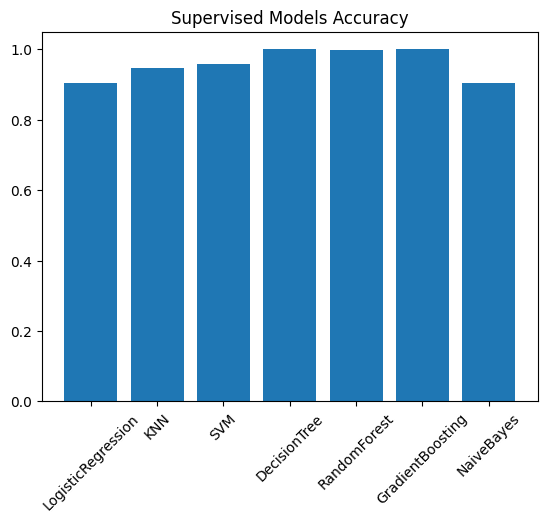

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "NaiveBayes": GaussianNB()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))

# Accuracy bar plot
plt.bar(results.keys(), results.values())
plt.xticks(rotation=45)
plt.title("Supervised Models Accuracy")
plt.show()


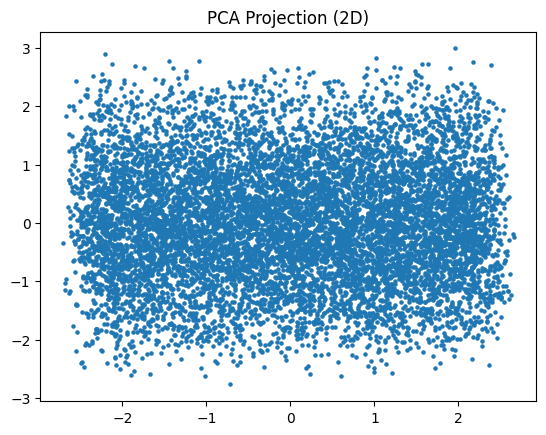

K=2, Silhouette Score=0.1690
K=3, Silhouette Score=0.1417
K=4, Silhouette Score=0.1377
K=5, Silhouette Score=0.1264


In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], s=5)
plt.title("PCA Projection (2D)")
plt.show()

# KMeans clustering and silhouette
for k in range(2,6):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    print(f"K={k}, Silhouette Score={sil:.4f}")


In [6]:
from collections import defaultdict
from sklearn.metrics import accuracy_score

# Discretize 2 features as states
states_df = X_imp[['CGPA','Communication_Skills']].copy()
states_df['CG_bin'] = pd.cut(states_df['CGPA'], bins=5, labels=False)
states_df['Comm_bin'] = pd.cut(states_df['Communication_Skills'], bins=5, labels=False)
states = list(zip(states_df['CG_bin'], states_df['Comm_bin']))

actions = [0,1]  # predict not placed/placed
Q = defaultdict(lambda: np.zeros(len(actions)))

alpha, gamma, epsilon, episodes = 0.1, 0.9, 0.2, 5
labels = y.values

# Training Q-table
for ep in range(episodes):
    for i, s in enumerate(states):
        if np.random.rand() < epsilon:
            a = np.random.choice(actions)
        else:
            a = int(np.argmax(Q[s]))
        reward = 1 if a == labels[i] else -1
        Q[s][a] = Q[s][a] + alpha*(reward - Q[s][a])

# Testing accuracy
test_states = list(zip(states_df['CG_bin'], states_df['Comm_bin']))
q_preds = [np.argmax(Q[s]) if s in Q else 0 for s in test_states]
print("Q-learning Toy Accuracy:", accuracy_score(y, q_preds))


Q-learning Toy Accuracy: 0.8697


MLP Accuracy: 0.9945


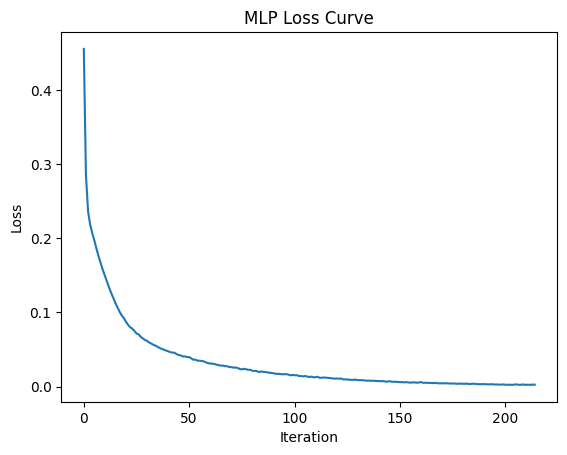

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, mlp_preds))

# Plot loss curve
plt.plot(mlp.loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


In [8]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression as SkLogReg

# Voting ensemble
voting = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier())
], voting='soft')
voting.fit(X_train, y_train)
print("Voting Accuracy:", accuracy_score(y_test, voting.predict(X_test)))

# Stacking ensemble
stack = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier())
], final_estimator=SkLogReg())
stack.fit(X_train, y_train)
print("Stacking Accuracy:", accuracy_score(y_test, stack.predict(X_test)))


Voting Accuracy: 1.0
Stacking Accuracy: 1.0


In [9]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2,5,10]
}

search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist,
                            n_iter=5, cv=3, scoring="accuracy", random_state=42)
search.fit(X_train, y_train)
print("Best Params:", search.best_params_)
print("Best Accuracy:", accuracy_score(y_test, search.best_estimator_.predict(X_test)))


Best Params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 20}
Best Accuracy: 0.9995
